### Implementation of algorithm for multi-level aggregation method to image segmentation

by Rachel Cox


**Source**: 
     Tiffany Inglis, Hans De Sterck, Geoffrey Sanders, Haig Djambazian, Robert Sladek,  
     Saravanan Sundararajan, & Thomas Hudson (2010). Multilevel Space-Time Aggregation
     for Bright Field Cell Microscopy. International Journal of Biomedical Imaging,
     [https://doi.org/10.1155/2010/582760]


In [1]:
# Execute 1

from PIL import Image, ImageOps
import numpy as np
from numpy import linalg as LA
from scipy.special import logsumexp


**Input:**  $n \times n$ greyscale image

**Output**  $n^2 \times m$ Boolean segmentation matrix U.

U has a row for each pixel and a column for each of the m segments.

Each pixel will be assigned to a segment. Therefore each row in matrix U will have one 1 to indicate it's membership in a particular segment.

First we declare a few global segmentation parameters:

- $\alpha$ - top-level intensity scaling factor
- $\tilde{\alpha}$ - coarse-level intensity rescaling factor
- $\beta$ - coarse-level variance rescaling factor
- $\theta$ - coarsening strength threshold
- $\gamma$ - saliency threshold
- $d_1$ - sharpening threshold
- $\sigma$ - segment detection threshold level
- $\rho$ - variance rescaling threshold level

In [2]:
# Parameter initializations
alpha = 10
alpha_tilde = 10 
beta = 100 
theta = 0.055
gamma = 0.05
d1 = 0.15
sigma = 1
rho = 4

In [3]:
# Read in the image. Obtain the pixel count

# Test Images:
# "checker_disk_60.png"
# "arrow_25.png"
# "astronaut.png"
# "cross.png"
# "thankyou.png"

# Select new test image as desired, simply change string name in line below
image_name = "checker_disk_60.png"

im = Image.open(image_name)

image_size = np.size(im)
nrows = image_size[0]
ncols =  image_size[1]

In [4]:
def imageVCycle(l,M,I,A,S,V,Gamma):
    
    # A.2 (1) Initialize Gamma vector
    if l <= sigma:
        for i in range(M):
            Gamma[i] = np.inf

    # A.2 (2) Coarsen the current graph
    C = coarsenAMG(A,Gamma,gamma,theta)
    

    # A.2 (3) Let M_new (M[r+1]) be the length of C-point vector
    M_new = len(C)
    M_old = M
    # A.2 (4) Increment level to the next coarsest level
    l = l+1

    # A.2 (5)If M = M_new (M[r]=M[r+1]) this means that no further
    # coarsening was obtained. Output U[r] as MxM identity
    if M_old == M_new:
        return np.identity(M_old)

    # A.2 (6)Generate interpolation matrix P of size MxM_new
    P = np.zeros((M_old,M_new))
    for i in range(M_new):
        P[C[i],i] = 1
    for i in range(M_old):
        if i not in C:
            P[i,:] = A[i,C]/np.sum(A[i,C])
           
    # A.2 (7)Next we create P-tilde, a column-scaled interpolation matrix of size
    # M x M_new
    P_tilde = np.zeros((M_old,M_new))
    for j in range(M_new):
        P_tilde[:,j] = P[:,j]/np.sum(P[:,j])
        
        
    # A.2 (8)Compute the coarse-level intensity vector to be an M_new x 1 vector
    P_tilde_transpose = P_tilde.transpose()
    I_new = np.dot(P_tilde_transpose, I)
    
    
    # A.2 (9)For each block on the current coarse level, r+1, compute a new
    # intensity variance measure relative to level r
    I_sq = I**2
    I_new_sq = I_new**2
    
    # Two ways to compute S_coarse are given (one commented out)
    #S_coarse = np.dot(P_tilde_transpose,I_sq) - I_new_sq
    first_product = np.dot(P_tilde_transpose,I_sq)
    S_coarse = np.subtract(first_product,I_new_sq)
 
    # Average the previously calculated variance measures for levels
    # finer than level r+1
    S_fine = np.dot(P_tilde_transpose,S)
    
    # Now define the coarse-level variance matrix S_new
    S_new = np.column_stack((S_fine,S_coarse))
    
    
    # A.2 (10)Define the coarse-level coupling matrix A, which has
    # dimension M_newxM_new
    P_transpose = P.transpose()
    A_new = np.dot(P_transpose,A)
    A_new = np.dot(A_new,P)

    
    # Rescale using the coarse-level intensity
    indices = np.nonzero(A_new)
    xindices = indices[0]
    yindices = indices[1]
    
    for i,j in zip(xindices,yindices):
        A_new[i][j] = A_new[i][j]*np.exp(-alpha_tilde*abs(I_new[i]-I_new[j]))
    
    # If l >= rho, then rescale using multilevel variance
    if l >= rho:
        for i in range(M_new):
            for j in range(M_new):
                norm = LA.norm(S_new[i,:]-S_new[j,:])
                A_new[i][j] = A_new[i][j]*np.exp(-beta*norm)            

    # A.2 (11)Define the coarse-level weighted area matrix W
    W_new = A_new
    
    # A.2 (12)Define the coarse-level area matrix V
    V_new = np.dot(P_transpose,V)
    V_new = np.dot(V_new,P)
    

    # A.2 (13)Define coarse-level weighted boundary length matrix L which
    # has dimension M_new x M_new
    L_new = -A_new
    for i in range(M_new):
        L_new[i][i] = -1*(np.sum(L_new[i,:])-L_new[i][i])
  
    
    # A.2 (14)Define the coarse-level boundary length matrix G_new (G[r+1])
    # which has dimension M_new x M_new
    G_new = -V_new
    for i in range(M_new):
        G_new[i][i] = -1*(np.sum(G_new[i,:])-G_new[i][i])
    
    
    # A.2 (15)Let the coarse-level saliency vector Gamma_new be an
    # M_new x 1 vector, determined as follows.
    # For each C-point i, if it was salient on level r, it will remaiin
    # salient on level r+1. Otherwise compute its saliency
    Gamma_new = np.zeros((M_new,1))
    for i in range(M_new):
        if Gamma[C[i]] == 0:
            Gamma_new[i] = 0
        else:
            # stop gap to elimate a division by 0
            if W_new[i][i] != 0:
                saliency = (L_new[i][i]/G_new[i][i])/(W_new[i][i]/V_new[i][i])
                if saliency > gamma:
                    Gamma_new[i] = saliency
                else:
                    Gamma_new[i] = 0
            else:
                Gamma_new[i] = Gamma_new[i-1]
                
                
    # A.2 (16)Recursively segment the coarse graph:
    U_new = imageVCycle(l,M_new,I_new,A_new,S_new,V_new,Gamma_new)

    
    # A.2 (17)Find the current segmentation matrix from the
    # coarse-level segmentation matrix
    U = np.dot(P,U_new)

    
    # A.2 (18)Sharpen overlapping segments
    u_rows = np.shape(U)[0]
    u_cols = np.shape(U)[1]

    
    for i in range(u_rows):
        for j in range(u_cols):
            if U[i][j] < d1:
                U[i][j] = 0
            elif U[i][j] > (1-d1):
                U[i][j] = 1
            else:
                U[i][j] = U[i][j]
    
    # A.2 (19)Return the current segmentation matrix
    return U

In [5]:
def coarsenAMG(A,Gamma,gamma,theta):
    
    # A.3 (1)Let M be the number of rows (or columns) of A
    M = np.shape(A)[0]
    
    # A.3 (2)Let A_bar be an MxM matrix containing only strong connections
    # First make a vector of the sum of each row except for the diagonal entry
    row_sum = np.zeros((M,1))
    for i in range(M):
        row_sum[i] = np.sum(A[i,:])
        row_sum[i] = row_sum[i] - A[i][i]
    
    A_bar = A
    for i in range(M):
        for j in range(M):
            if (i == j) or (A[i][j] < theta*row_sum[i]):
                A_bar[i][j] = 0
    
    # A.3 (3)Let llambda be an Mx1 vector in which each lambda[i]
    # denotes the number of nonzero entries in column i of A_hat
    llambda = np.zeros((M,1))
    for j in range(M):
        llambda[j] = np.count_nonzero(A_bar[:,j])

    
    # A.3 (4)Let T be an Mx1 zero vector that keeps track of thee set
    # to which each node is assigned. For node i, Ti = 0 means it is unassigned
    # Ti=1 means it is a C-point, and Ti=2 means it is an F-point
    T = np.zeros((M,1))
    
    # A.3 (5) If Gamma[i]<gamma, then Ti =  1 and llambdai=0
    # Salient nodes are designated as C-points
    for i in range(M):
        if Gamma[i] < gamma:
            T[i] = 1
            llambda[i] = 0
            
    # A.3 (6) while loop to handle the main part of the grid coarsening 
    while np.count_nonzero(T) < M:

        j = 0
        while T[j] != 0 or llambda[j] < np.max(llambda):
            j += 1
            
        T[j] = 1
        llambda[j] = 0
        
        K = []
        for k in range(M):
            if (A_bar[k][j]>0) and (T[k]==0):
                K.append(k)
                
        for k in K:
            T[k] = 2
            llambda[k] = 0
            
            H = []
            for h in range(M):
                if A_bar[k][h]>0 and T[h] == 0:
                    H.append(h)
                    
            for h in H:
                llambda[h] = llambda[h]+1

        
    C = []
    for i in range(M):
        if T[i] == 1:
            C.append(i)    

    return C

In [6]:
# Initialize the level 1 (finest level) parameters

# level number r, nxn is size of pixel matrix
n = nrows
mc = ncols
r = 5
N = n*mc

l = 1
M = N

# row major vector operation to get a list of pixel values (rowmajor)
pixels = list(im.getdata())

# Next check if input image is in color or in grayscale
rgb = len(pixels[0])

for pi in range(len(pixels)):
    if rgb > 1:
        pixel_sum = 0
        for p in range(rgb):
            pixel_sum += pixels[pi][p]
        average = pixel_sum/rgb
        pixels[pi] = average
        
        # Rescale so that 255 -> 1 and 0 -> 0
        pixels[pi] = pixels[pi]/255
    else:
        pass
    
# Our intensity vector (row-major order) is called I
I = np.array(pixels)

# Next we define a coupling matrix A
# In order to do so, we must find the neighboring pixels
# from the original image. 
# Special cases: First column, last column, first row, last row

# Initialize A to be a matrix of zeros. A will be a sparse matrix.
A = np.zeros((M,M)) 

# Each row in the coupling matrix corrresponds to one pixel in the original image. We only
# set 2-4 entries per row corresponding to the neighbors
for i in range(M):
    # First we define the top row. Top row pixels have a E,W, and S neighbor. Special cases
    # are the top left pixel (E and S neighbors only) and the top right pixel (W and S neighbors only)-handled 
    # in following if conditional.
    if i < (ncols-1):
        if i == 0: # top left corner pixel
            A[i][i]=1
            A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
            A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
            
        else:
            A[i][i]=1
            A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
            A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
            A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
            
    # Next we define the edge weights for the right edge of the image. We consider the special cases of the
    # pixel in the top right corner and the bottom right corner.
    elif ((i+1)%ncols) == 0:
        if i == (ncols-1): # top right corner pixel
            A[i][i]=1
            A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
            A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
        elif i == (ncols*nrows-1): # bottom right corner pixel
            A[i][i]=1
            A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
            A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
            
        else:
            A[i][i]=1
            A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
            A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
            A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
                                 
    # Next we define the edge weights for the left edge of the image. We consider the special case of the
    # pixel in the bottom left corner. (top left pixel handled above)
    elif (i%ncols)==0 and i>0:
        if i == (M-(ncols-1)): # bottom left corner pixel
            A[i][i]=1
            A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
            A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
        
        else:
            A[i][i]=1
            A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
            A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
            if i < M-ncols:
                A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
            
    # Next we define the edge weights for the bottom edge of the image. Special cases for the bottom left
    # and bottom right have already been taken care of above.
    elif (i>(M-ncols)) and i < (M-1):
        A[i][i]=1
        A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
        A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
        A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
        
    # Finally, we define edge weights for the middle pixels. Each has a N, S, E, and W neighbor.
    else:
        A[i][i] = 1
        A[i][i-1] = np.exp(-1*alpha**abs(I[i]-I[i-1])) # W neighbor
        A[i][i+1] = np.exp(-1*alpha**abs(I[i]-I[i+1])) # E neighbor
        A[i][i-ncols] = np.exp(-1*alpha**abs(I[i]-I[i-ncols])) # N neighbor
        A[i][i+ncols] = np.exp(-1*alpha**abs(I[i]-I[i+ncols])) # S neighbor
           
        
# Define the variance matrix S to be a MxM zero matrix on the first level
S = np.zeros((M,M))


# Define the weighted boundary length matrix L to be an MxM matrix
#L =np.zeros((M,M))
L = -A
for i in range(M):
    L[i][i] = np.sum(A[i,:])-A[i][i]

# Define Area matrix V to be an MxM matrix defined in the 
# following way.           
V = np.ones((M,M))
zero_values = np.where(A==0)
xindex = zero_values[0]
yindex = zero_values[1]

for ii, jj in zip(xindex,yindex):
    V[ii][jj] = 0
            
# Define Boundary length matrix G to be an MxM matrix defined
# in the following way.
G = -V
for i in range(M):
    G[i][i] = np.sum(V[i,:])-V[i][i]

            
# Define a saliency vector Gamma which has the dimensions Mx1
# New addition to the Segmentation by Weighted Aggregation 
# SWA method - attempts to segment image into salient (prominent) groups
# The saliency measure can be interpreted as the average similarity 
# along the boundary of block i divided by the average similarity in 
# interior of block i.
# A block is salient if it has low average similarity to its neighboring blocks
# 
Gamma = np.zeros((M,1))
for i in range(M):
    Gamma[i] = L[i][i]/G[i][i]


# Initial call to the recursive graph segmentation function
# This is the output of the non-recursive part of the segmentation 
# algorithm. U is an Nxm Boolean segmentation matrix U
# N is the number of pixels. So this matrix will have one 1 in each row.
# U_ij = 1 means that pixel i belongs to the jth segment.

U = imageVCycle(l,M,I,A,S,V,Gamma)


# Assign pixels uniquely to segments

u_rows = np.shape(U)[0]
u_cols = np.shape(U)[1]

# Recall that N is the number of piixels in row-major
# order. We loop through each of the N rows in matrix U
# and record a 1 in the column with the max value

for pix_id in range(u_rows):
    max_k = 0
    index = 0
    for seg_num in range(u_cols):
        if U[pix_id][seg_num]>max_k:
            max_k = U[pix_id][seg_num]
            index = seg_num
    U[pix_id][index]=1
    for seg_num in range(u_cols):
        if seg_num != index:
            U[pix_id][seg_num]=0
        else:
            pass
     

In [7]:
# Should be m columns (corresponding to m groups)
np.shape(U)

(3600, 9)

In [8]:
print("Number of Segments Detected:",np.shape(U)[1])

Number of Segments Detected: 9


In [9]:
# Getting segmentation results ready for viewing
import matplotlib.pylab as plt

U_image = np.zeros((nrows*ncols,1))
for ii in range(np.shape(U)[0]):
    for jj in range(np.shape(U)[1]):
        if U[ii,jj] == 1:
            U_image[ii] = jj
            
segmented_image = U_image.reshape((ncols,nrows))

#plt.imshow(im) # Display original image if desired

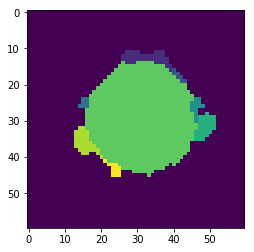

In [10]:
plt.imshow(segmented_image)

In [11]:
plt.imsave('segments.png', segmented_image)

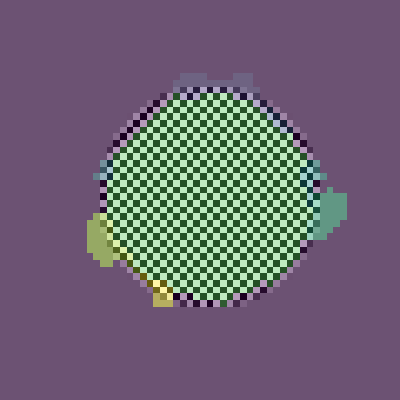

In [12]:
# Generate an overlay of the original image with the segmentation results
try:
    from PIL import Image
except ImportError:
    import Image

background = Image.open(image_name)
overlay = Image.open("segments.png")

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.4)
new_img.save("overlay.png","PNG")

new_img = new_img.resize((400,400))

new_img